# TIGRESS 21-cm Radiative Transfer
Trey Wenger - February 2024, updated September 2024

Performs 21-cm radiative transfer on TIGRESS data:
* extracts physical conditions from TIGRESS
* saves those data to FITS cubes
* performs 21-cm radiative transfer along a given axis
* saves those data to FITS cubes
* smooths emission cubes
* generates sythetic spectral observations

## Load simulation data

In [1]:
import astro_tigress

# path to TIGRESS data
dir_master = "/media/drive1/tigress"
model_id = "R8_4pc"
dataset = "MHD_PI"

# load simulation
print("Loading simulation...")
model = astro_tigress.Model(model_id, dir_master)
model.load(300, dataset=dataset)

if dataset == "MHD":
    data_shape = [256, 256, 256]
    grid = model.MHD.grid
elif dataset == "MHD_PI":
    # load central region
    data_shape = [256, 256, 320]
    # box has physical units (pc)
    grid = model.MHD_PI.ytds.box([-512, -512, -640], [512, 512, 640])
else:
    raise ValueError(f"dataset {dataset} not found")

Loading simulation...


In [2]:
import multiprocessing as mp
from multiprocessing.shared_memory import SharedMemory

_PHASE_NAMES = ["All", "CNM", "LNM", "WNM"]

def load_shared_memory(data_shape, output_shape, create=False):
    """
    Create or load shared memory resources for multiprocessing

    Inputs:
        data_shape :: tuple
            Data shape
        output_shape :: tuple
            Radiative transfer output shape
        create :: boolean
            If True, create new shared resources. Otherwise, access existing resources
    """
    data_nbytes = np.prod(data_shape) * 8
    output_nbytes = np.prod(output_shape) * 8

    # storage for all shared memory buffers
    sh_mem = []

    # storage for numpy data that reference shared memory buffers
    data = {}

    # simulation data
    data_vars = ["kin_temp", "spin_temp", "velocity", "sigma"]
    for data_var in data_vars:
        mem = SharedMemory(name=data_var, create=create, size=data_nbytes)
        sh_mem.append(mem)
        data[data_var] = np.ndarray(data_shape, dtype=float, buffer=mem.buf)

    data["nHI"] = {}
    data["NHI"] = {}
    for phase_name in _PHASE_NAMES:
        mem = SharedMemory(name=f"nHI_{phase_name}", create=create, size=data_nbytes)
        sh_mem.append(mem)
        data["nHI"][phase_name] = np.ndarray(data_shape, dtype=float, buffer=mem.buf)
        mem = SharedMemory(name=f"NHI_{phase_name}", create=create, size=output_nbytes)
        sh_mem.append(mem)
        data["NHI"][phase_name] = np.ndarray(output_shape, dtype=float, buffer=mem.buf)

    # radiative transfer outputs
    data_vars = ["TB_on", "TB_off"]
    for data_var in data_vars:
        data[data_var] = {}
        for phase_name in _PHASE_NAMES:
            mem = SharedMemory(
                name=f"{data_var}_{phase_name}", create=create, size=output_nbytes
            )
            sh_mem.append(mem)
            data[data_var][phase_name] = np.ndarray(
                output_shape, dtype=float, buffer=mem.buf
            )

    data_vars = ["TB_mean_temp", "TB_mean_density"]
    for data_var in data_vars:
        mem = SharedMemory(name=data_var, create=create, size=output_nbytes)
        sh_mem.append(mem)
        data[data_var] = np.ndarray(output_shape, dtype=float, buffer=mem.buf)

    return data, sh_mem

In [3]:
import numpy as np

# observed spectral axis
spec_velocity = np.arange(-150.0, 150.5, 0.5)

# shared memory for multiprocessing radiative transfer
print("Initializing shared memory...")
observe_axis = 1 # observe along y-axis
output_shape = (len(spec_velocity),) + tuple(
    [shape for i, shape in enumerate(data_shape) if i != observe_axis]
)
data, sh_mem = load_shared_memory(data_shape, output_shape, create=True)

Initializing shared memory...


## Prepare simulation data

In [4]:
# Extract simulation data
print("Extracting simulation data...")
data["kin_temp"][:] = (
    grid[("gas", "temperature")].in_units("K").value.reshape(data_shape)
)
nH = grid[("gas", "nH")].in_units("cm**-3").value.reshape(data_shape)
pressure = (
    grid[("gas", "pressure")].in_units("dyn/cm**2").value.reshape(data_shape)
    * 7.24297e15
)  # P/kB (K cm-3)
if dataset == "MHD_PI":
    xHI = grid[("athena", "specific_scalar[0]")].value.reshape(data_shape)
else:
    xHI = np.ones(data_shape)
observe = ["x", "y", "z"][observe_axis]
data["velocity"][:] = (
    grid[("gas", f"velocity_{observe}")].in_units("km/s").value.reshape(data_shape)
)

Extracting simulation data...


In [5]:
# assume gas with T > 14000 K is collizionally ionized
xHI[data["kin_temp"] > 1.4e4] = 0.0

# molecular, neutral, and ionized gas fraction
nHI = nH * xHI
nHII = nH * (1.0 - xHI)
nH2_thresh = 50.0
nH2 = nHI.copy()
nHI[nHI > nH2_thresh] = 0.0
nH2[nHI < nH2_thresh] = 0.0
HI_mask = nHI > 0.0

In [6]:
from astropy.io import fits

outdir = "/media/drive1/tigress_results/R8_4pc_MHD_PI"

# save FITS
print("Saving simulation data...")
hdu = fits.PrimaryHDU(nHI)
hdu.writeto(f"{outdir}/nHI.fits", overwrite=True)
hdu = fits.PrimaryHDU(pressure)
hdu.writeto(f"{outdir}/pressure.fits", overwrite=True)
hdu = fits.PrimaryHDU(np.log10(nHI))
hdu.writeto(f"{outdir}/log10_nHI.fits", overwrite=True)
hdu = fits.PrimaryHDU(xHI)
hdu.writeto(f"{outdir}/xHI.fits", overwrite=True)
hdu = fits.PrimaryHDU(nHII)
hdu.writeto(f"{outdir}/nHII.fits", overwrite=True)
hdu = fits.PrimaryHDU(np.log10(nHII))
hdu.writeto(f"{outdir}/log10_nHII.fits", overwrite=True)
hdu = fits.PrimaryHDU(nH2)
hdu.writeto(f"{outdir}/nH2.fits", overwrite=True)
hdu = fits.PrimaryHDU(np.log10(nH2))
hdu.writeto(f"{outdir}/log10_nH2.fits", overwrite=True)
hdu = fits.PrimaryHDU(data["kin_temp"])
hdu.writeto(f"{outdir}/kinetic_temperature.fits", overwrite=True)
hdu = fits.PrimaryHDU(data["velocity"])
hdu.writeto(f"{outdir}/velocity.fits", overwrite=True)

Saving simulation data...


/tmp/ipykernel_295527/2105237728.py:11: RuntimeWarning: divide by zero encountered in log10
  hdu = fits.PrimaryHDU(np.log10(nHI))
/tmp/ipykernel_295527/2105237728.py:17: RuntimeWarning: divide by zero encountered in log10
  hdu = fits.PrimaryHDU(np.log10(nHII))
/tmp/ipykernel_295527/2105237728.py:21: RuntimeWarning: divide by zero encountered in log10
  hdu = fits.PrimaryHDU(np.log10(nH2))


In [7]:
# cell size (square cells)
dx_cm = grid[("gas", "dx")][0].to("cm").value

# HI column density
NHI = nH.sum(axis=observe_axis) * dx_cm
hdu = fits.PrimaryHDU(NHI)
hdu.writeto(f"{outdir}/NHI.fits", overwrite=True)
hdu = fits.PrimaryHDU(np.log10(NHI))
hdu.writeto(f"{outdir}/log10_NHI.fits", overwrite=True)

In [8]:
# HI phase temperature thresholds
print("Clipping HI phases...")
data["mask"] = {}
data["mask"]["All"] = HI_mask.copy()
data["mask"]["CNM"] = HI_mask.copy() * (data["kin_temp"] < 500.0)
data["mask"]["LNM"] = (
    HI_mask.copy() * (data["kin_temp"] > 500.0) * (data["kin_temp"] < 5000.0)
)
data["mask"]["WNM"] = HI_mask.copy() * (data["kin_temp"] > 5000.0)
for phase in _PHASE_NAMES:
    nHI_phase = nHI.copy()
    nHI_phase[~data["mask"][phase]] = 0.0
    data["nHI"][phase][:] = nHI_phase
    NHI_phase = nHI_phase.sum(axis=observe_axis) * dx_cm
    data["NHI"][phase][:] = NHI_phase
    hdu = fits.PrimaryHDU(nHI_phase)
    hdu.writeto(f"{outdir}/nHI_{phase}.fits", overwrite=True)
    hdu = fits.PrimaryHDU(np.log10(nHI_phase))
    hdu.writeto(f"{outdir}/log10_nHI_{phase}.fits", overwrite=True)
    hdu = fits.PrimaryHDU(NHI_phase)
    hdu.writeto(f"{outdir}/NHI_{phase}.fits", overwrite=True)
    hdu = fits.PrimaryHDU(np.log10(NHI_phase))
    hdu.writeto(f"{outdir}/log10_NHI_{phase}.fits", overwrite=True)

Clipping HI phases...


/tmp/ipykernel_295527/2715830735.py:18: RuntimeWarning: divide by zero encountered in log10
  hdu = fits.PrimaryHDU(np.log10(nHI_phase))
/tmp/ipykernel_295527/2715830735.py:22: RuntimeWarning: divide by zero encountered in log10
  hdu = fits.PrimaryHDU(np.log10(NHI_phase))


## Evaluate spin temperature, thermal broadening

In [9]:
def calc_spin_temp(kin_temp, density):
    """
    Calculate the spin temperature following Kim et al. (2014) eq. 4

    Inputs:
        kin_temp :: scalar (K)
            Gas kinetic temperature
        density :: scalar (cm-3)
            Gas density

    Returns:
        spin_temp :: scalar (K)
            Spin temperature
    """
    TR = 3.77  # CMB
    TD = kin_temp
    n_alpha = 1.0e-6  # Lya photon number density cm-3
    y_alpha = 5.9e11 * n_alpha / (TD * np.sqrt(kin_temp))
    T0 = 0.0681  # K
    A10 = 2.8843e-15  # s-1 Einstein A
    k10 = np.zeros_like(kin_temp)
    T2 = kin_temp / 100.0
    k10[kin_temp < 300.0] = 1.19e-10 * T2[kin_temp < 300.0] ** (
        0.74 - 0.20 * np.log(T2[kin_temp < 300.0])
    )
    k10[kin_temp > 300.0] = (
        2.24e-10 * T2[kin_temp > 300.0] ** 0.207 * np.exp(-0.876 / T2[kin_temp > 300.0])
    )
    R10 = density * k10
    y_c = T0 * R10 / (kin_temp * A10)
    spin_temp = (TR + y_c * kin_temp + y_alpha * TD) / (1.0 + y_c + y_alpha)
    return spin_temp

In [10]:
wf = False

# spin temperature
print("Calculating spin temperature...")
if wf:
    data["spin_temp"][:] = data["kin_temp"]
else:
    data["spin_temp"][:] = calc_spin_temp(data["kin_temp"], nH)
hdu = fits.PrimaryHDU(data["spin_temp"])
hdu.writeto(f"{outdir}/spin_temperature.fits", overwrite=True)

Calculating spin temperature...


In [11]:
# turbulent broadening, assume 2 km/s on 4 pc scales
fwhm_turbulent = 2.0  # km/s

# thermal broadening (km/s)
fwhm_thermal = 21.4 * np.sqrt(data["kin_temp"] / 1.0e4)
hdu = fits.PrimaryHDU(fwhm_thermal)
hdu.writeto(f"{outdir}/fwhm_thermal.fits", overwrite=True)

# line width
fwhm = np.sqrt(fwhm_thermal**2.0 + fwhm_turbulent**2.0)
data["sigma"][:] = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))

# background continuum source
Tbg = 1000.0

## Perform radiative transfer

In [12]:
def simple_slice(arr, inds, axis):
    # this does the same as np.take() except only supports simple slicing, not
    # advanced indexing, and thus is much faster
    # From: https://stackoverflow.com/questions/24398708/slicing-a-numpy-array-along-a-dynamically-specified-axis
    # e.g., simple_slice(arr, 0, 1) == arr[:, 0, :]
    # e.g., simple_slice(arr, slice(1, None), 1) == arr[:, 1:, :]
    sl = [slice(None)] * arr.ndim
    sl[axis] = inds
    return arr[tuple(sl)]

In [13]:
def radiative_transfer(
    idx,
    spec_vel,
    dx_cm,
    Tbg,
    axis,
    data_shape,
    output_shape,
):
    """
    Process the radiative transfer for a single pixel.

    Inputs:
        idx :: integer
            Pixel index
        spec_vel :: 1-D array of scalars
            Spectral velocity axis (km/s)
        dx_cm :: scalar
            Simulation grid resolution (cm)
        Tbg :: scalar
            Background brightness temperature for ON observation (K)
        axis :: integer
            Axis to treat as line-of-sight
        data_shape :: tuple
            Data shape
        output_shape :: tuple
            Radiative transfer output shape

    Returns:
        idx :: integer
            Same as input
    """
    # load shared memory
    (
        data,
        _,
    ) = load_shared_memory(data_shape, output_shape, create=False)

    # radiative transfer constant
    const = 1.82243e18  # cm-2 (K km s-1)-1

    # background CMB + synchrotron
    Tcmb = 3.77  # K

    # line profile
    line_profile = np.exp(
        -0.5 * (data["velocity"] - spec_vel) ** 2.0 / data["sigma"] ** 2.0
    ) / np.sqrt(2.0 * np.pi * data["sigma"] ** 2.0)

    for phase in _PHASE_NAMES:
        # optical depth
        tau = data["nHI"][phase] * dx_cm * line_profile / data["spin_temp"] / const
        sum_tau = np.nancumsum(tau, axis=axis)

        # background
        TB_back_on = (Tcmb + Tbg) * np.exp(-simple_slice(sum_tau, -1, axis))
        TB_back_off = Tcmb * np.exp(-simple_slice(sum_tau, -1, axis))

        # front surface
        TB_front = simple_slice(data["spin_temp"], 0, axis) * (
            1.0 - np.exp(-simple_slice(tau, 0, axis))
        )

        # everything else
        TB_middle = (
            simple_slice(data["spin_temp"], slice(1, None), axis)
            * (1.0 - np.exp(-simple_slice(tau, slice(1, None), axis)))
            * np.exp(-simple_slice(sum_tau, slice(None, -1), axis))
        )

        data["TB_on"][phase][idx] = (
            TB_back_on + np.nansum(TB_middle, axis=axis) + TB_front
        )
        data["TB_off"][phase][idx] = (
            TB_back_off + np.nansum(TB_middle, axis=axis) + TB_front
        )

        if phase == "All":
            # weighted mean kinetic temperature
            TB_front_temp = simple_slice(data["kin_temp"], 0, axis) * TB_front
            TB_middle_temp = np.nansum(
                simple_slice(data["kin_temp"], slice(1, None), axis) * TB_middle,
                axis=axis,
            )
            data["TB_mean_temp"][idx] = (TB_middle_temp + TB_front_temp) / data[
                "TB_off"
            ][phase][idx]

            # weighted mean density
            TB_front_density = simple_slice(data["nHI"][phase], 0, axis) * TB_front
            TB_middle_density = np.nansum(
                simple_slice(data["nHI"][phase], slice(1, None), axis) * TB_middle,
                axis=axis,
            )
            data["TB_mean_density"][idx] = (
                TB_middle_density + TB_front_density
            ) / data["TB_off"][phase][idx]
    return idx

In [14]:
from tqdm.notebook import tqdm

num_processes = mp.cpu_count()
print(f"Running {num_processes} parallel processes")

# Track progress
print("Performing radiative transfer...")
pbar = tqdm(total=len(spec_velocity))

def update(result):
    pbar.update()

with mp.Pool(processes=num_processes) as p:
    for idx, spec_vel in enumerate(spec_velocity):
        p.apply_async(
            radiative_transfer,
            args=(
                idx,
                spec_vel,
                dx_cm,
                Tbg,
                observe_axis,
                data_shape,
                output_shape,
            ),
            callback=update,
        )
    p.close()
    p.join()

Running 24 parallel processes
Performing radiative transfer...


  0%|          | 0/601 [00:00<?, ?it/s]

In [15]:
# save FITS
hdu = fits.PrimaryHDU(data["TB_mean_temp"])
hdu.writeto(f"{outdir}/HI_TB_mean_temp.fits", overwrite=True)
hdu = fits.PrimaryHDU(data["TB_mean_density"])
hdu.writeto(f"{outdir}/HI_TB_mean_density.fits", overwrite=True)
for phase in _PHASE_NAMES:
    hdu = fits.PrimaryHDU(data["TB_on"][phase])
    hdu.writeto(f"{outdir}/HI_{phase}_TB_on.fits", overwrite=True)
    hdu = fits.PrimaryHDU(data["TB_off"][phase])
    hdu.writeto(f"{outdir}/HI_{phase}_TB_off.fits", overwrite=True)

In [20]:
# free shared memory
for mem in sh_mem:
    mem.close()
    mem.unlink()

## Plot simulation data

In [22]:
# load data
with fits.open(f"{outdir}/nHI.fits") as hdulist:
    nHI = hdulist[0].data
with fits.open(f"{outdir}/pressure.fits") as hdulist:
    pressure = hdulist[0].data
with fits.open(f"{outdir}/xHI.fits") as hdulist:
    xHI = hdulist[0].data
with fits.open(f"{outdir}/kinetic_temperature.fits") as hdulist:
    kin_temp = hdulist[0].data
with fits.open(f"{outdir}/spin_temperature.fits") as hdulist:
    spin_temp = hdulist[0].data

In [23]:
phases = {
    "All": {"color": "black"},
    "CNM": {"color": "blue"},
    "LNM": {"color": "green"},
    "WNM": {"color": "orange"},
}

# masks
HI_mask = nHI > 0.0
phases["All"]["mask"] = HI_mask
phases["CNM"]["mask"] = HI_mask * (kin_temp < 500.0)
phases["LNM"]["mask"] = HI_mask * (kin_temp > 500.0) * (kin_temp < 5000.0)
phases["WNM"]["mask"] = HI_mask * (kin_temp > 5000.0)
for phase in phases.keys():
    nHI_phase = nHI.copy()
    nHI_phase[~phases[phase]["mask"]] = 0.0
    phases[phase]["nHI"] = nHI_phase

/tmp/ipykernel_295527/1459812214.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


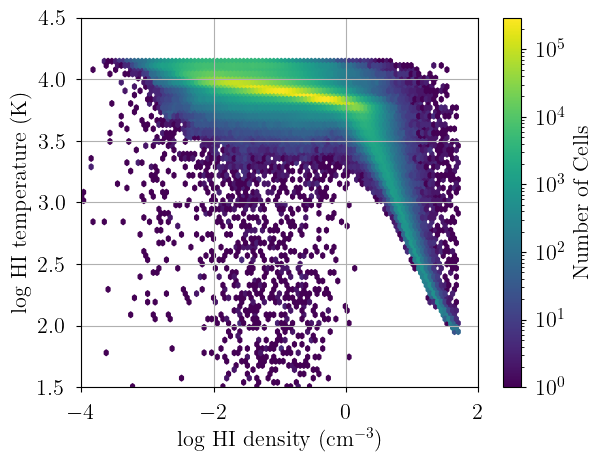

In [28]:
import matplotlib.pyplot as plt

# phase diagram
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(kin_temp[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel("log HI temperature (K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(1.5, 4.5)
fig.savefig(f"{outdir}/phase.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/2960999815.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


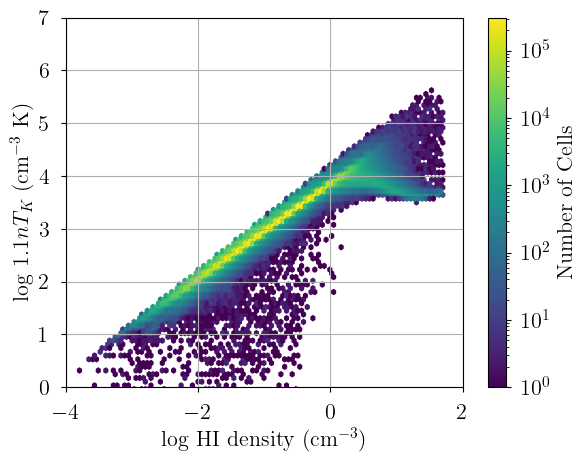

In [29]:
# phase diagram
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(1.1 * nHI[HI_mask] * kin_temp[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel(r"log $1.1 n T_K$ (cm$^{-3}$ K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(0.0, 7.0)
fig.savefig(f"{outdir}/phase_nT.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/1299967833.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


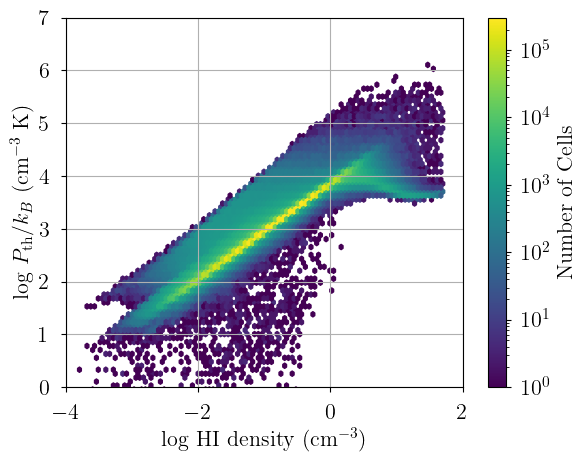

In [30]:
# phase diagram
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(pressure[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel(r"log $P_{\rm th}/k_B$ (cm$^{-3}$ K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(0.0, 7.0)
fig.savefig(f"{outdir}/phase_pressure.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/3465608136.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


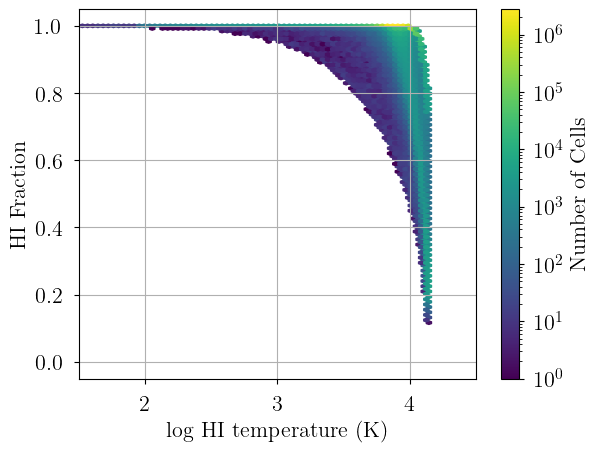

In [31]:
# ionization fraction vs. temperature
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(kin_temp[HI_mask]).flatten(),
    xHI[HI_mask].flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel("log HI temperature (K)")
ax.set_ylabel("HI Fraction")
ax.set_xlim(1.5, 4.5)
ax.set_ylim(-0.05, 1.05)
fig.savefig(f"{outdir}/xHI_temperature.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/3220684839.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


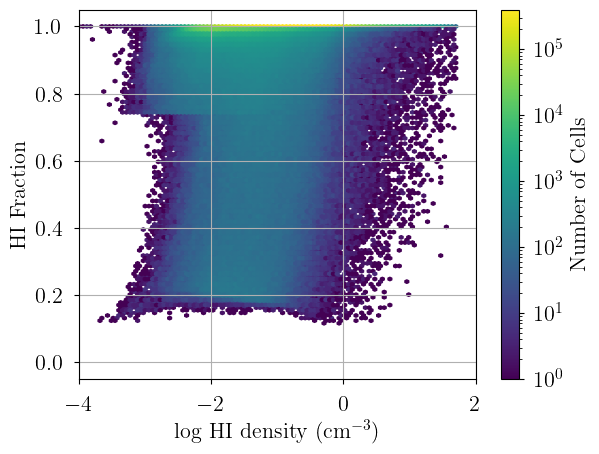

In [32]:
# ionization fraction vs. density
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    xHI[HI_mask].flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel("HI Fraction")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(-0.05, 1.05)
fig.savefig(f"{outdir}/xHI_density.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/2904924696.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


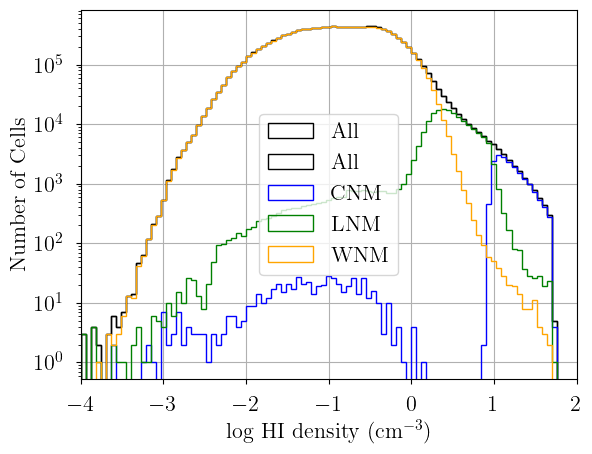

In [33]:
# density histogram
fig, ax = plt.subplots()
bins = np.linspace(-4.0, 2.0, 100)
ax.hist(
    np.log10(nHI[HI_mask]).flatten(),
    bins=bins,
    color="k",
    histtype="step",
    label="All",
)
for phase in phases.keys():
    nHI_phase = phases[phase]["nHI"]
    mask = phases[phase]["mask"]
    ax.hist(
        np.log10(nHI_phase[mask]).flatten(),
        bins=bins,
        color=phases[phase]["color"],
        histtype="step",
        label=phase,
    )
ax.legend(loc="best")
ax.set_yscale("log")
ax.set_xlim(-4.0, 2.0)
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel("Number of Cells")
fig.savefig(f"{outdir}/HI_density_pdf.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/2447173173.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


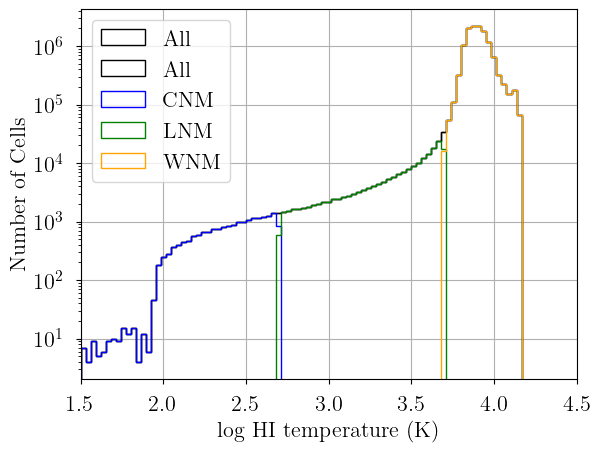

In [34]:
# temperature histogram
fig, ax = plt.subplots()
bins = np.linspace(1.5, 4.5, 100)
ax.hist(
    np.log10(kin_temp[HI_mask]).flatten(),
    bins=bins,
    color="k",
    histtype="step",
    label="All",
)
for phase in phases.keys():
    mask = phases[phase]["mask"]
    ax.hist(
        np.log10(kin_temp[mask]).flatten(),
        bins=bins,
        color=phases[phase]["color"],
        histtype="step",
        label=phase,
    )
ax.legend(loc="best")
ax.set_yscale("log")
ax.set_xlim(1.5, 4.5)
ax.set_xlabel("log HI temperature (K)")
ax.set_ylabel("Number of Cells")
fig.savefig(f"{outdir}/HI_temperature_pdf.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/2208281144.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


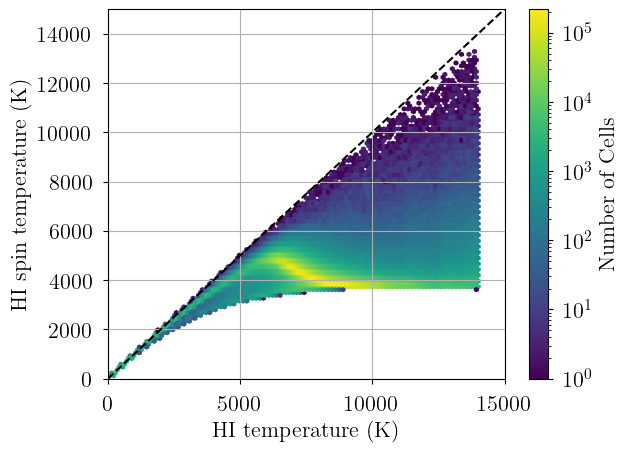

In [35]:
# spin temperature vs. kinetic temperature
fig, ax = plt.subplots()
cax = ax.hexbin(
    kin_temp[HI_mask].flatten(),
    spin_temp[HI_mask].flatten(),
    bins="log",
    mincnt=1,
)
ax.plot([0.0, 15000.0], [0.0, 15000.0], "k--")
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel("HI temperature (K)")
ax.set_ylabel("HI spin temperature (K)")
ax.set_xlim(0.0, 15000.0)
ax.set_ylim(0.0, 15000.0)
fig.savefig(f"{outdir}/HI_spin_temp_temperature.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_295527/1875598757.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


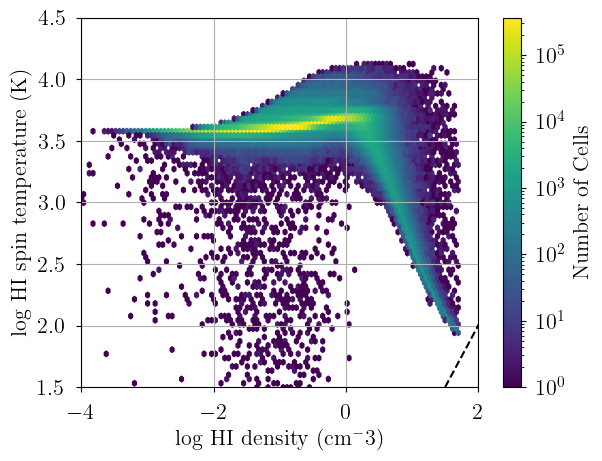

In [36]:
# spin temperature vs. density
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(spin_temp[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
ax.plot([1.5, 4.5], [1.5, 4.5], "k--")
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(f"log HI density (cm$^{-3}$)")
ax.set_ylabel("log HI spin temperature (K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(1.5, 4.5)
fig.savefig(f"{outdir}/HI_spin_temp_density.pdf", bbox_inches="tight")
fig.show()

## Smooth data

In [21]:
from scipy.ndimage import gaussian_filter

# Smooth to mimic emission observations
# 4 pc cell @ 5 kpc = 2.75 arcmin
# GBT beam @ 21 cm ~ 8 arcmin
# Convolve with FWHM = 8.0 arcmin = 2.9 pixels
#              sigma = 3.4 arcmin = 1.2 pixels
sigma = 8.0/(2.0*np.sqrt(2.0*np.log(2.0)))/2.75

for phase in _PHASE_NAMES:
    with fits.open(f"{outdir}/HI_{phase}_TB_on.fits") as hdulist:
        data = hdulist[0].data
    smooth_data = gaussian_filter(data, sigma=sigma, axes=[1, 2])
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/HI_{phase}_TB_on_smooth.fits", overwrite=True)

    with fits.open(f"{outdir}/HI_{phase}_TB_off.fits") as hdulist:
        data = hdulist[0].data
    smooth_data = gaussian_filter(data, sigma=sigma, axes=[1, 2])
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/HI_{phase}_TB_off_smooth.fits", overwrite=True)

with fits.open(f"{outdir}/HI_TB_mean_temp.fits") as hdulist:
    data = hdulist[0].data
smooth_data = gaussian_filter(data, sigma=sigma, axes=[1, 2])
hdu = fits.PrimaryHDU(smooth_data)
hdu.writeto(f"{outdir}/HI_TB_mean_temp_smooth.fits", overwrite=True)

with fits.open(f"{outdir}/HI_TB_mean_density.fits") as hdulist:
    data = hdulist[0].data
smooth_data = gaussian_filter(data, sigma=sigma, axes=[1, 2])
hdu = fits.PrimaryHDU(smooth_data)
hdu.writeto(f"{outdir}/HI_TB_mean_density_smooth.fits", overwrite=True)

## Extract spectra

In [40]:
# Get data
with fits.open(f"{outdir}/HI_All_TB_off.fits") as hdulist:
    TB_off = hdulist[0].data
with fits.open(f"{outdir}/HI_All_TB_off_smooth.fits") as hdulist:
    TB_off_smooth = hdulist[0].data
with fits.open(f"{outdir}/HI_All_TB_on.fits") as hdulist:
    TB_on = hdulist[0].data

In [41]:
# background CMB + synchrotron
Tcmb = 3.77  # K
# background continuum source
Tbg = 1000.0

# Optical depth rms = 0.001 to mimic 21-SPONGE
# Emission rms = 0.2 K to mimic 21-SPONGE
tau_rms = 0.001
TB_rms = 0.2

# velocity axis
velocity = np.arange(-150.0, 150.1, 0.5)

In [42]:
from tqdm.notebook import tqdm
rng = np.random.RandomState(seed=1234)

num_spectra = np.prod(TB_on.shape[1:])

emission_spectra = np.ones((num_spectra, len(velocity))) * np.nan
emission_smooth_spectra = np.ones((num_spectra, len(velocity))) * np.nan
absorption_spectra = np.ones((num_spectra, len(velocity))) * np.nan
location = np.ones((num_spectra, 2)) * np.nan

# Track progress
print("Extracting spectra...")
pbar = tqdm(total=num_spectra)
for i in range(num_spectra):
    x, y = np.unravel_index(i, TB_off.shape[1:])
    location[i] = np.array([x, y])
    emission_spectra[i] = TB_off[:, x, y] - Tcmb + TB_rms*rng.randn(len(velocity))
    emission_smooth_spectra[i] = TB_off_smooth[:, x, y] - Tcmb + TB_rms*rng.randn(len(velocity))
    # optical depth 
    absorption_spectra[i] = -np.log((TB_on[:, x, y] - TB_off[:, x, y]) / Tbg) + tau_rms*rng.randn(len(velocity))
    pbar.update()

Extracting spectra...


  0%|          | 0/81920 [00:00<?, ?it/s]

In [44]:
import pickle

# package for gausspy
emission = {
    "data_list": [emission_spectra[i] for i in range(num_spectra)],
    "x_values": [velocity for i in range(num_spectra)],
    "errors": [np.ones_like(velocity) * TB_rms for i in range(num_spectra)],
    "location": [location[i] for i in range(num_spectra)],
}
emission_smooth = {
    "data_list": [emission_smooth_spectra[i] for i in range(num_spectra)],
    "x_values": [velocity for i in range(num_spectra)],
    "errors": [np.ones_like(velocity) * TB_rms for i in range(num_spectra)],
    "location": [location[i] for i in range(num_spectra)],
}
absorption = {
    "data_list": [absorption_spectra[i] for i in range(num_spectra)],
    "x_values": [velocity for i in range(num_spectra)],
    "errors": [np.ones_like(velocity) * tau_rms for i in range(num_spectra)],
    "location": [location[i] for i in range(num_spectra)],
}
joint = {
    "data_list": [absorption_spectra[i] for i in range(num_spectra)],
    "data_list_em": [emission_spectra[i] for i in range(num_spectra)],
    "x_values": [velocity for i in range(num_spectra)],
    "x_values_em": [velocity for i in range(num_spectra)],
    "errors": [np.ones_like(velocity) * tau_rms for i in range(num_spectra)],
    "errors_em": [np.ones_like(velocity) * TB_rms for i in range(num_spectra)],
    "location": [location[i] for i in range(num_spectra)],
}
joint_smooth = {
    "data_list": [absorption_spectra[i] for i in range(num_spectra)],
    "data_list_em": [emission_smooth_spectra[i] for i in range(num_spectra)],
    "x_values": [velocity for i in range(num_spectra)],
    "x_values_em": [velocity for i in range(num_spectra)],
    "errors": [np.ones_like(velocity) * tau_rms for i in range(num_spectra)],
    "errors_em": [np.ones_like(velocity) * TB_rms for i in range(num_spectra)],
    "location": [location[i] for i in range(num_spectra)],
}

with open(f"{outdir}/HI_emission_spectra.pkl", "wb") as f:
    pickle.dump(emission, f)
with open(f"{outdir}/HI_emission_smooth_spectra.pkl", "wb") as f:
    pickle.dump(emission_smooth, f)
with open(f"{outdir}/HI_absorption_spectra.pkl", "wb") as f:
    pickle.dump(absorption, f)
with open(f"{outdir}/HI_joint_spectra.pkl", "wb") as f:
    pickle.dump(joint, f)
with open(f"{outdir}/HI_joint_smooth_spectra.pkl", "wb") as f:
    pickle.dump(joint_smooth, f)

/tmp/ipykernel_295527/817655377.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


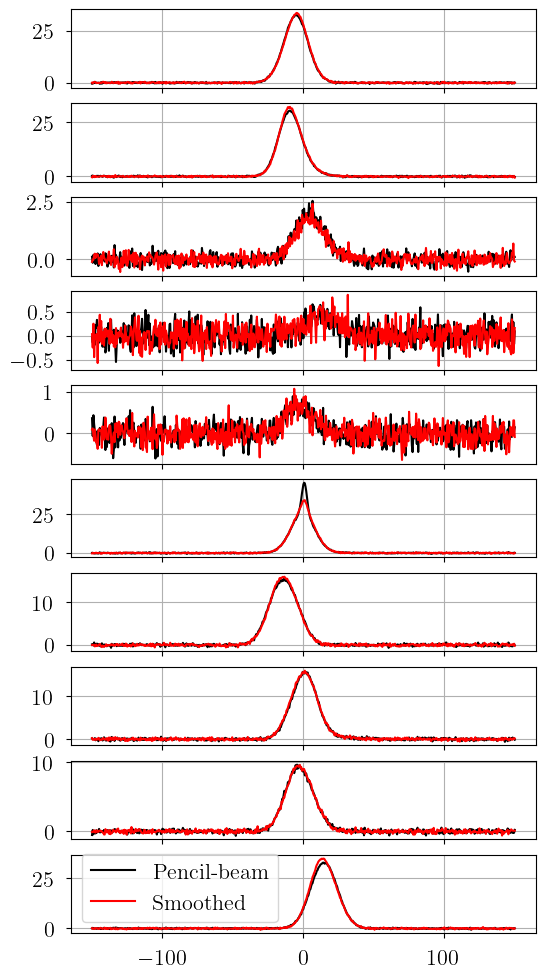

In [47]:
# plot some example spectra
fig, axes = plt.subplots(10, sharex=True, figsize=(6, 12))
for i, ax in enumerate(axes):
    idx = np.random.choice(num_spectra)
    ax.plot(velocity, emission_spectra[idx], 'k-', label="Pencil-beam")
    ax.plot(velocity, emission_smooth_spectra[idx], 'r-', label="Smoothed")
axes[-1].legend(loc='best')
fig.show()

/tmp/ipykernel_295527/2293754604.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


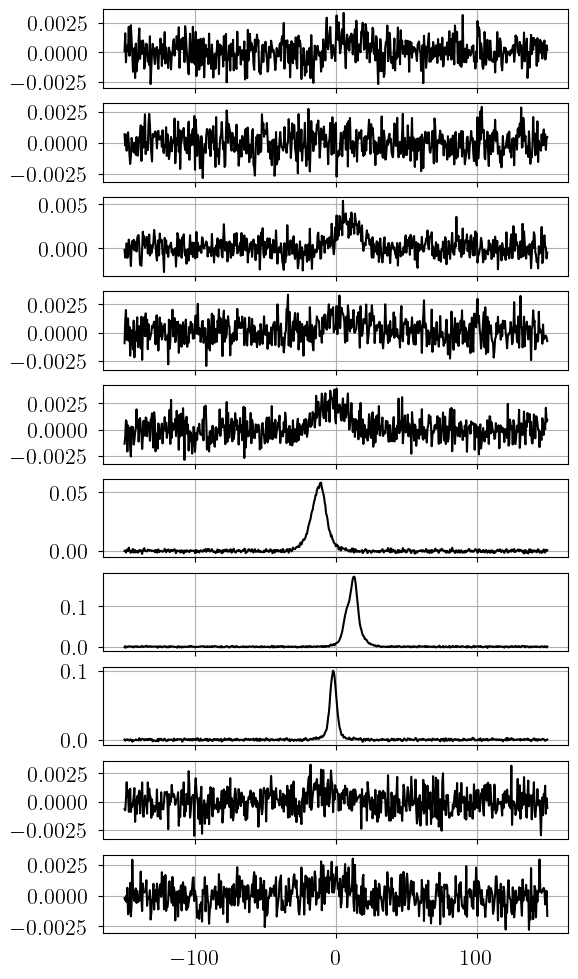

In [49]:
# plot some example spectra
fig, axes = plt.subplots(10, sharex=True, figsize=(6, 12))
for i, ax in enumerate(axes):
    idx = np.random.choice(num_spectra)
    ax.plot(velocity, absorption_spectra[idx], 'k-')
fig.show()

In [50]:
num_spectra

np.int64(81920)

np.float64(1.2353771640553004)